In [1]:
using AirBorne.ETL.YFinance: get_interday_data, get_chart_data, parse_intraday_raw_data
using Dates: DateTime,datetime2unix
using Dates
using RollingFunctions: rolling
using Statistics
using StatsBase
using Plots
using LinearAlgebra
using ToeplitzMatrices
using Random
using Distributions
using RollingFunctions
using DirectSearch

function regress(data, lookback=1, lookahead=1)
    num_samples = length(data) - lookback - lookahead + 1
    inputs = zeros(num_samples, lookback)
    outputs = zeros(num_samples, lookahead)
    for i  in 1:num_samples
        inputs[i,:] = (data[i:i+lookback-1]) 
        outputs[i,:] = data[i+lookback:i+lookback+lookahead-1]
    end
    params = inputs \ outputs 
    return params
end

function regress_forecast(data, lookback=1, lookahead=1)
    params = regress(data, lookback, lookahead)
    forecast = data[end-lookback+1:end] * params
    return forecast
end

function apply_differencing(s, d=1)
    differenced_series = s
    init_vals = []
    for i in 1:d
        push!(init_vals, differenced_series[1])
        differenced_series = diff(differenced_series)
    end
    return differenced_series, init_vals
end
function undo_differencing(s, inits, d=1)
    # assert(d == length(inits), "The number of initial values should be equal to the differencing order")
    undifferenced_series = s
    # println(cumsum(undifferenced_series) .+ 6)
    for i in 1:d
        current_init = pop!(inits) # pop the last element
        undifferenced_series = [current_init; cumsum(undifferenced_series) .+ current_init]
    end
    return undifferenced_series
end

function arima(series, p::Int, d::Int, q::Int, F::Int)
    # Apply differencing
    differenced_series, inits = apply_differencing(series, d)
    ar_predictions = zeros(F)
    # Calculate the autocorrelation matrix
    autocorr = autocor(differenced_series; demean=true)
    # Create the Toeplitz matrix
    R_matrix = Toeplitz(autocorr[1:p], autocorr[1:p])
    r_vector = autocorr[2:p+1]

    # # Solve the Yule-Walker equations
    ar_coeffs = R_matrix \ r_vector
    if p > 0
        for i in 1:F

            coeffs = R_matrix \ autocorr[1+i:p+i]
            ar_predictions[i] = sum(differenced_series[end-p+1:end] .* reverse(coeffs))
        end
        
    end

    ma_predictions = zeros(F)
    if q > 0
        sample_var = var(diff(differenced_series))
        # println("sample_var differenced: ", var(diff(differenced_series)))
        # println("sample_var: ", sample_var)
        ma_var = (1/(length(differenced_series) - p - 1)) * sum((differenced_series[i+p+1] - sum(differenced_series[i+1:i+p] .* reverse(ar_coeffs)))^2 for i in 1:length(differenced_series)-p-1)
        # ma_var = sample_var * ma_coeff
        ma_samples = rand(Normal(0, sqrt(ma_var/(length(differenced_series) - p - 1))), F)
        ma_predictions = ma_samples
    end
    # Forecast
    forecast = ar_predictions .+ ma_predictions
    # Undo differencing
    restored_series = undo_differencing([differenced_series;  forecast], inits, d)
    return restored_series[end-F+1:end]
end

arima (generic function with 1 method)

In [4]:
function run_combined(data, weights; P=1, p=1, d=1, q=1, F=1, reparameterise_windows=[0, 0], dates=Nothing, doubled=false) 
    step_map = Dict()
    step_error = []
    max_reparameterise_window = maximum(reparameterise_windows)
    load_idx = max(p, max_reparameterise_window, round(Int, length(data) / 2))
    loading_data = data[1:load_idx]
    running_data = data[load_idx+1:end]

    function run_func(x)
        all_data = [loading_data; x]
        if reparameterise_windows[1] > 0
            linear_data = all_data[end-reparameterise_windows[1]+1:end]
        end
        if reparameterise_windows[2] > 0
            arima_data = all_data[end-reparameterise_windows[2]+1:end]
        end
        if doubled
            W, Q = weights[1:F], weights[F+1:end]
            forecast = []
            linear_forecast = regress_forecast(linear_data, P, F)
            arima_forecast = arima(arima_data, p, d, q, F)
            for i in 1:F
                forecast = [forecast; (W[i] * linear_forecast[i]) + (Q[i] * arima_forecast[i])]
            end
        else
            forecast = (weights[1] .* regress_forecast(all_data, P, F)) .+ (weights[2] .* arima(all_data, p, d, q, F))
        end
        return forecast
    end

    forecast = running(run_func, running_data, length(running_data))
    # println(forecast)
    for i in 1:F
        if i == 1
            fill_data = []
        else
            fill_data = running_data[2:i]
        end
        fill_data = running_data[1:i]
        step_map[i] = [fill_data;collect(Iterators.flatten(f[i] for f in forecast))][1:length(running_data)]

        e = step_map[i][i+1:end] .- running_data[i+1:end]
        push!(step_error, mean((e).^2))
    end

    if dates != Nothing
        ticks = Dates.format.(dates, "dd-mm-yyyy")
        step_size = round(Int, length(running_data) / 10)
        tick_idx = 1:step_size:length(ticks)
        println(tick_idx)
        step_plot = plot(running_data[F+1:end], xticks = (1:step_size:length(running_data),ticks[end-length(running_data)+1:step_size:end]), xrot=60, label="Actual", size=(800, 400))
    else
        step_plot = plot(running_data[F+1:end], label="Actual", size=(800, 400))
    end
    for i in 1:F
        plot!(step_map[i][F+1:end], label="Forecast $i step")
    end
    return step_plot, step_error
end

run_combined (generic function with 1 method)

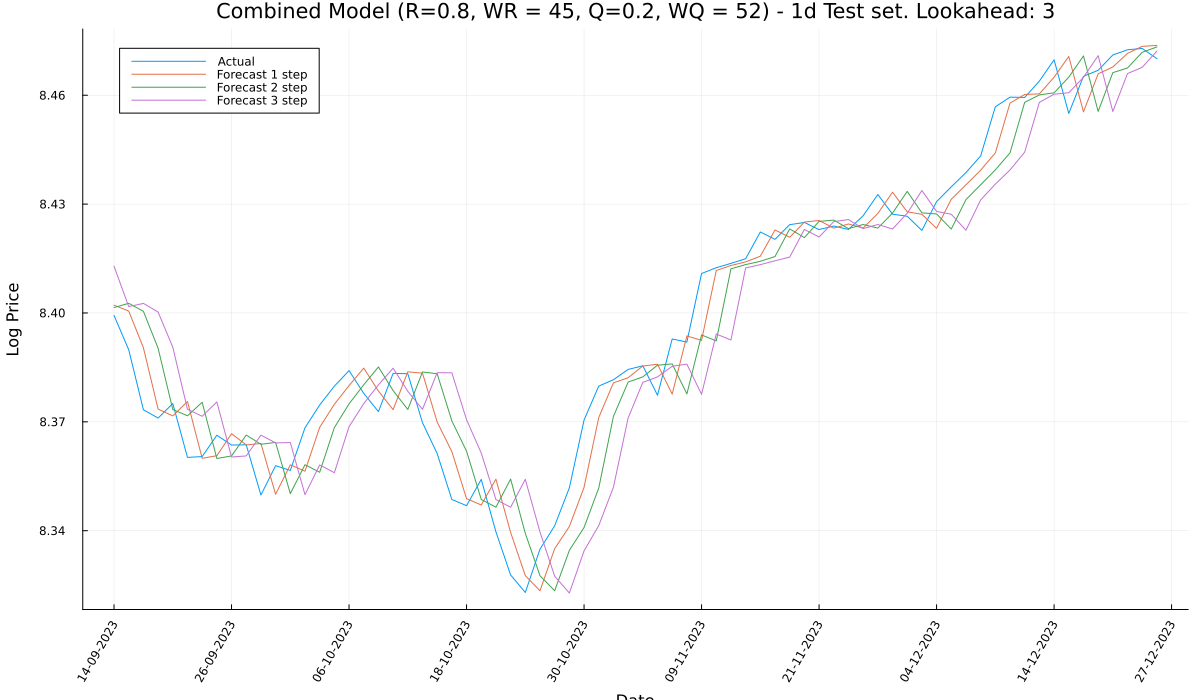

MADS Run Summary
--------------------------------------------------
Feasible Solution           [0.8, 0.2]
Feasible Cost               0.00037409145271315576
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  50
Function Evaluations        15
Cache hits                  186
Optimization Status         Mesh Precision limit

Runtime                     2.178433895111084
Search Time                 7.013e-6
Poll Time                   0.002816823
Blackbox Evaluation Time    1.9138182039999982
[0.8, 0.2]
1:8:753
Mean Squared Error: 0.00015041061175423152


In [6]:
freq = "1d"
ticker = "^GSPC"
unix(x) = string(round(Int, datetime2unix(DateTime(x))))
sp500 = parse_intraday_raw_data(get_chart_data(ticker, unix("2021-01-01"), unix("2024-01-01"), freq))
price = log.(sp500.close)
train_idx = round(Int, length(price) * 0.8)
train, test = price[1:train_idx], price[train_idx+1:end]

# tmp_plot, errors = run_combined(train, 0.2; P=1, p=1, d=3, q=1, F=1)
# display(tmp_plot)
F, P, p, d, q = 3, 1, 4, 1, 1

function obj(x)
    tmp_plot, errors = run_combined(train, x; P=P, p=p, d=d, q=q, F=F, reparameterise_windows=[45, 52], doubled=false)
    return mean(errors)
end

combined_problem = DSProblem(2, objective=obj, initial_point=[0.80, 0.20], granularity=[0.01, 0.01])
Optimize!(combined_problem)
println(combined_problem.x)
params = combined_problem.x
tmp_plot, errors = run_combined(test, params; P=P, p=p, d=d, q=q, F=F, reparameterise_windows=[45, 52], dates=sp500.date)
plot!(tmp_plot, title="Combined Model (R=$(params[1]), WR = 45, Q=$(params[2]), WQ = 52) - $(freq) Test set. Lookahead: $(F)", size=(1200, 700), ylabel="Log Price", xlabel="Date", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
savefig(tmp_plot, "combine_plots/single_combined_forecast_F$(F).svg")
display(tmp_plot)
println("Mean Squared Error: ", mean(errors))

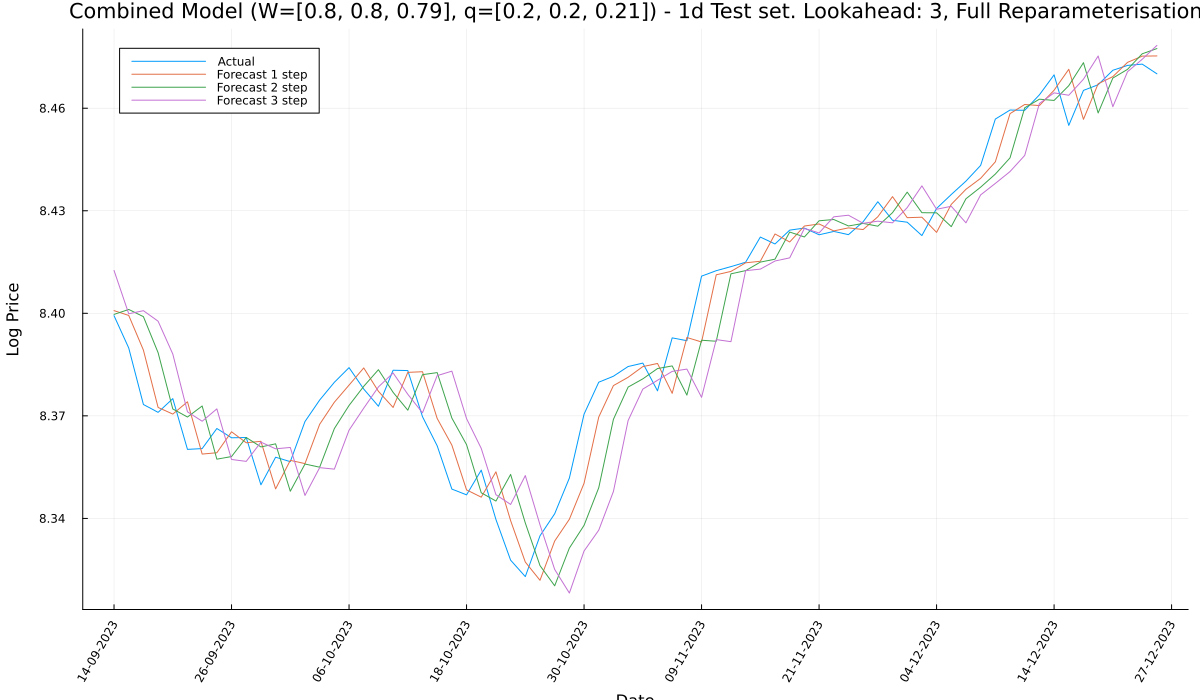

MADS Run Summary
------------------------------------------------------------
Feasible Solution           [0.8, 0.8, 0.79, 0.2, 0.2, 0.21]
Feasible Cost               0.00039989942674137493
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  54
Function Evaluations        291
Cache hits                  358
Optimization Status         Mesh Precision limit

Runtime                     16.128069162368774
Search Time                 1.0887000000000003e-5
Poll Time                   0.02653548300000001
Blackbox Evaluation Time    15.882236590000003
[0.8, 0.8, 0.79, 0.2, 0.2, 0.21]
1:8:753
Mean Squared Error: 0.00015528922136445516


In [12]:
F = 3
dims = 2 * F

function obj(x)
    tmp_plot, errors = run_combined(train, x; P=P, p=p, d=d, q=q, F=F, reparameterise_windows=[45, 52], doubled=true)
    return mean(errors)
end

doubled_combined_problem = DSProblem(dims, objective=obj, initial_point=[fill(0.80, F);fill(0.20, F)], granularity=fill(0.01, dims))
Optimize!(doubled_combined_problem)
println(doubled_combined_problem.x)
params = doubled_combined_problem.x
tmp_plot, errors = run_combined(test, params; P=P, p=p, d=d, q=q, F=F, reparameterise_windows=[45, 52], dates=sp500.date, doubled=true)
plot!(tmp_plot, title="Combined Model (W=$(params[1:F]), q=$(params[F+1:end])) - $(freq) Test set. Lookahead: $(F), Full Reparameterisation", size=(1200, 700), ylabel="Log Price", xlabel="Date", left_margin=5Plots.mm, bottom_margin=5Plots.mm)
savefig(tmp_plot, "combine_plots/doubled_combined_forecast_F$(F).svg")
display(tmp_plot)
println("Mean Squared Error: ", mean(errors))

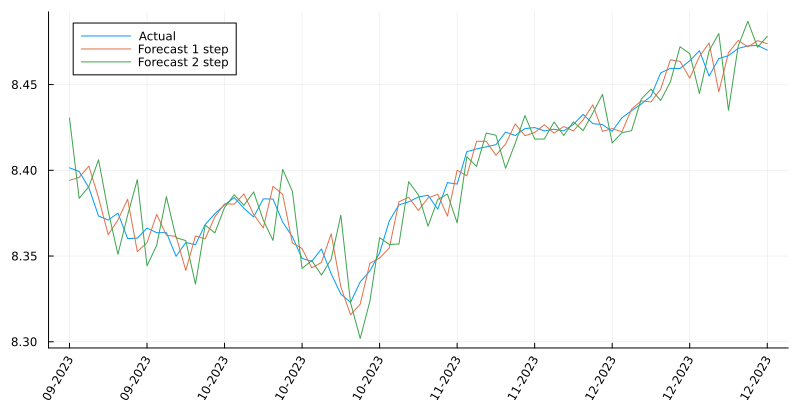

1:8:753


In [94]:
tmp_plot, errors = run_combined(test, params; P=P, p=p, d=d, q=q, F=F, reparameterise_window=0, dates=sp500.date, doubled=true)
display(tmp_plot)